In [4]:
import numpy as np
import cupy as cp
import idx2numpy
import matplotlib.pyplot as plt
import pickle
import os


print(cp.cuda.runtime.getDeviceCount())

1


In [5]:
# load training images and labels
train_data=idx2numpy.convert_from_file('MNIST/train-images-idx3-ubyte')
train_data = np.reshape(train_data,(60000,28*28))
train_label = idx2numpy.convert_from_file('MNIST/train-labels-idx1-ubyte')

# load testing images and labels
test_data=idx2numpy.convert_from_file('MNIST/t10k-images-idx3-ubyte')
test_data = np.reshape(test_data,(10000,28*28))
test_label = idx2numpy.convert_from_file('MNIST/t10k-labels-idx1-ubyte')


In [6]:
#move data to gpu

X = cp.array(train_data ,dtype=float) / 255
# normalize features
# X_normer = cp.sqrt(cp.sum(X*X, axis=0))

# X =  X / X_normer
# X[cp.isnan(X)] = 0

Y = cp.zeros((X.shape[0], 10)) #one hot encode
Y[cp.arange(X.shape[0]),train_label] = 1

X_test = cp.array(test_data ,dtype=float) / 255

# X_test =  X_test / X_normer
# X_test[cp.isnan(X_test)] = 0

Y_test = cp.zeros((X_test.shape[0], 10)) #one hot encode
Y_test[cp.arange(X_test.shape[0]),test_label] = 1

In [7]:
def relu(x):
  return cp.maximum(x, 0) 

# column-wise softmax
# X[N,d]: softmax over d
def softmax(X):
  m = X.max(axis=1)
  return cp.transpose(cp.exp(X.T-m)/cp.sum(cp.exp(X.T-m), axis=0))

def sigmoid(X):
  return 1/(1+cp.exp(-X))


In [8]:
class myMLP1():
  def __init__(self, optimizer='sgd', debug=0, struct=[], final_activation='relu',\
               loss='mse', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization 
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.final_activation=final_activation     # activation function 
    self.loss = loss               # the loss used for training objective 
    if self.loss=='ce':
      self.final_activation='softmax'
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights 

    self.struct = struct           # network structure: e.g. [100], [500, 200], 
                                   #                         [100,100,100]

  # initialize internal struct/variables for input/output 
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets 
  def initialization(self, X, Y, X_normer=None):
    cp.random.seed(self.random_state)
    self.X_normer = X_normer

    input = X.shape[1]                # input dimension 
    self.layers = len(self.struct)    # number of hidden layers 
    self.W = [0]*(self.layers+1)      # list for all weight matrices
    self.b = [0]*(self.layers+1)      # list for all bias vectors 
    self.W_grad = [0]*(self.layers+1) # list for weight gradients
    self.b_grad = [0]*(self.layers+1) # list for bias gradients 

    # create weight matrices for all hidden layers 
    for l in range(self.layers):  
      output = self.struct[l]
      self.W[l] = 4.90*(cp.random.rand(input, output)-0.5)*self.init_range/cp.sqrt(output+input)
      self.b[l] = cp.zeros(output)
      self.W_grad[l] = cp.random.rand(input, output)
      self.b_grad[l] = cp.zeros(output)
      input = output 

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W[self.layers] = 4.90*(cp.random.rand(input, output)-0.5)*self.init_range/cp.sqrt(output+input)
    self.b[self.layers] = cp.zeros(output)
    self.W_grad[self.layers] = cp.random.rand(input, output)
    self.b_grad[self.layers] = cp.zeros(output)


  # forward pass to compute outputs for a mini-batch X
  # if return_Z=True, also save all hidden activation 
  # (refer to the box on page 166)
  # input =>  X[B,d]: a batch of input vectors
  # if return_Z=False, return only y[B,K]
  # otherwise, return activations for all layers (including hidden layers) 
  def forward(self, X, return_Z=False):
    # list to save all hidden nodes' activation values 
    if (return_Z):
      Zs = [0] * (self.layers+2)
    else:
      Zs = [0]

    Z = X
    if(return_Z):
        Zs[0] = Z
    # forward pass from all hidden layers
    for l in range(self.layers): 
      Z = relu(Z @ self.W[l]  + self.b[l])
      if(return_Z):
        Zs[l+1] = Z

    #forward pass for output layer
    l = self.layers
    if self.final_activation=='relu':
      y = relu(Z @ self.W[l] + self.b[l])
    elif self.final_activation=='sigmoid':
      y = sigmoid(Z @ self.W[l] + self.b[l])
    elif self.final_activation=='softmax':
      y = softmax(Z @ self.W[l] + self.b[l])
    else:
      print("fatal no activation")
      return
    if (return_Z):
      Zs[l+1] = y
    else:
      Zs[0] = y
    
    return Zs

  def MSE(self,X,Y):
    Z = self.forward(X,return_Z=False)
    S = Z[0]-Y
    if (self.X_normer is not None):
      S = S*self.X_normer
    mse = cp.mean((S*S).sum(axis=1))
    return mse

  # backward pass to compute gradients for a mini-batch of inputs X and targets Y
  # Zs: list of all hidden activation values (pre-computed by a forward pass)
  # return gradients of all weight matrices and bias vectors 
  # (refer to the box on page 188)
  def backward(self, X, Y, Zs):
 
    # output layer
    # calculate the corisponding error for the output layor based on the final activation function
    l = len(Zs)-1
    if self.loss=='mse': 
      if self.final_activation=='relu':
        e = 2*(Zs[l]-Y) * cp.heaviside(Zs[l],0)   #MSE relu
      elif self.final_activation=='sigmoid':
        e = 2*(Zs[l]-Y) * Zs[l] * (1 - Zs[l])     #MSE sigmoid
      else:
        print("fatal no activation")
        return
    elif self.loss=='ce':
      if self.final_activation=='softmax':        #CE softmax
        e = Zs[l] - Y  # error signals for output layer 
      else:
        print("fatal no activation")
        return
    else:
      print("fatal no loss")
      return

    WG = cp.einsum('bo,bi->bio', e, Zs[l-1])
    self.W_grad[l-1] = cp.mean(WG,axis=0) 
    self.b_grad[l-1] = cp.mean(e,axis=0)

    # backward for all hidden layers
    for l in range(self.layers,0,-1):
      e = ( e @ self.W[l].T ) * cp.heaviside(Zs[l],0) 
      WG = cp.einsum('bo,bi->bio', e, Zs[l-1])
      self.W_grad[l-1] = cp.mean(WG,axis=0)
      self.b_grad[l-1] = cp.mean(e,axis=0)

    return self.W_grad, self.b_grad

  # mini-batch SGD to update model parameters (Algorith 8.8 on page 189) 
  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets
  def sgd(self, X, Y):
    n = X.shape[0]            # number of samples
    
    lr = self.lr
    if self.loss=='mse': 
      errorsM = cp.zeros(self.max_epochs)
      if self.debug>1:    
        print(f"first MSE = {self.MSE(X,X):.2f}")
    elif self.loss=='ce':
      errorsA = cp.zeros(self.max_epochs)
      errorsC = cp.zeros(self.max_epochs)
      if self.debug>1:    
        Z = self.forward(X, return_Z=False)
        erC = -cp.mean (cp.log(Z[0][Y==1]))

        train_label = cp.argmax(Y, axis=1)
        train_res = cp.argmax(Z[0], axis=1)
        erA = cp.count_nonzero(cp.equal(train_res,train_label))/train_label.size

        print(f'first C = {erC:.5f}  A = {100*erA:.2f}%')


    for epoch in range(self.max_epochs):
      indices = cp.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        Zs = self.forward(X_batch, return_Z=True)

        W_grad, b_grad = self.backward(X_batch, Y_batch, Zs)

        for l in range(self.layers+1):
          self.W[l] -= lr * W_grad[l]
          self.b[l] -= lr * b_grad[l]

      # plot all learning curves (A, B, C)
      
      if self.loss=='mse':
        errorsM[epoch] = self.MSE(X,X)
      
        if(self.debug>1):
          print(f'epoch = {epoch} (lr={lr:.2}): MSE = {errorsM[epoch]:.2f}')
      elif self.loss=='ce':
        Z = self.forward(X, return_Z=False)
        errorsC[epoch] = -cp.mean (cp.log(Z[0][Y==1]))

        train_label = cp.argmax(Y, axis=1)
        train_res = cp.argmax(Z[0], axis=1)
        errorsA[epoch] = cp.count_nonzero(cp.equal(train_res,train_label))/train_label.size

        if(self.debug>1):
          print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing
    if self.loss=='ce': 
      return errorsA 
    elif self.loss=='mse':
      return errorsM
    return "OOPS no loss"

  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets          
  def fit(self, X, Y, X_normer=None):

    self.initialization(X, Y, X_normer)

    errors = self.sgd(X, Y)

    return errors 

  # X[N,d]: input features;
  # return: labels (NOT one-hot)
  def predict(self, X):
    Y = self.forward(X,return_Z=False)
    return cp.argmax(Y[0], axis=1)
    

In [9]:
class auto_encoder():
    def __init__(self, struct=[], lr=1.0, final_activation='relu', max_epochs=12, batch_size=10, annealing=0.9, debug=0):
        self.mlp = myMLP1(struct=struct, 
                          debug=debug, 
                          max_epochs=max_epochs, 
                          annealing=annealing, 
                          batch_size=batch_size, 
                          lr=lr, 
                          final_activation=final_activation, 
                          random_state=1)

    def fit(self,X,X_normer=None):
        return self.mlp.fit(X,X,X_normer=X_normer)

    def encode(self,X):
        Z = X
        L = (len(self.mlp.struct)+1)//2 
        # forward pass from all hidden layers
        for l in range(L): 
            Z = relu(Z @ self.mlp.W[l]  + self.mlp.b[l])
        return Z

    def decode(self,Z):
        L = (len(self.mlp.struct)+1)//2 
        # forward pass from all hidden layers
        for l in range(L,len(self.mlp.struct)): 
            Z = relu(Z @ self.mlp.W[l]  + self.mlp.b[l])
        
        #output layor
        l = self.mlp.layers
        if self.mlp.final_activation=="relu":
            Z = relu(Z @ self.mlp.W[l] + self.mlp.b[l])
        elif self.mlp.final_activation=="sigmoid":
            Z = sigmoid(Z @ self.mlp.W[l] + self.mlp.b[l])
        else:
            print("fatal no final activation")
            return
        return Z


In [ ]:
class mySVM():
    def __init__(self, kernel='linear', optimizer='smo', threshold=0.001, 
                 max_epochs=100_000, C=10, gamma=1.0, recal_bads=100, lr=1.0, batch_size=2, debug=0,
                smo_chooser=1,smo_calc_loss=300):
        self.kernel = kernel        # kernel type
        self.max_epochs = max_epochs   # max epochs in PGD
        self.threshold = threshold     # threshold to filter out support vectors
        self.gamma = gamma
        self.losses = []
        self.C = C     # C for the soft-margin term
        self.recal_bads = recal_bads #how often (epoch) re calculate the KKT bads
        self.smo_chooser = smo_chooser

        self.optimizer = optimizer  # which optimizer is used to solve quadratic programming
        self.lr = lr                # max learning rate in PGD
        self.batch_size = batch_size 
        self.debug = debug
        self.sum_all_moves = 0
        self.smo_calc_loss = smo_calc_loss

        
        self.choose_j=False
        self.b = None

    def plot(self):
        plt.subplot(1, 3, 1)
        plt.title("final alphas")
        plt.plot(range(self.alpha.shape[0]),self.alpha.get(), ".")
        
        plt.subplot(1, 3, 2)
        plt.title("losses")
        plt.plot(self.losses)

        if self.smo_chooser!=0:
            plt.subplot(1, 3, 3)
            plt.title("bads")
            plt.plot(self.alpha[self.lower].get(),"y.")
            plt.plot(self.alpha[self.higher].get(),"r.")

        # plt.plot(range(self.lower.shape[0]),self.lower.get(),"y.")
        # plt.plot(range(self.higher.shape[0]),self.higher.get(),"r.")

            print("BADS (not KKT equality)")
            print("a=0 and a=C", len(self.lower))
            print("0<a<C", len(self.higher))

        plt.show()
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        return
    
    # return the objective we are trying to maximise with current alphas
    def objective(self,Q,a):
        # estimate so its faster, not that much faster so we dont use this
        # idx = a>self.threshold
        # obj = a[idx].sum() - (1/2) * (a[idx]).T @ (Q[idx][:,idx]) @ (a[idx])
        obj = a.sum() - (1/2) * (a).T @ Q @ (a)
        return obj.item()

        
    def Kernel(self, X, Y):
        if (self.kernel == 'linear'):
            K = X.T @ Y
        elif (self.kernel == 'rbf'):
            K = cp.tile((X*X).sum(axis=0).reshape(-1,1), (1, Y.shape[1])) + cp.tile((Y*Y).sum(axis=0), (X.shape[1],1)) - 2*X.T@Y
            K = cp.exp(-self.gamma*K)
        else:
            print("bad kernel")
        return K

  # construct matrix Q from any kernel function for dual SVM optimization
    def QuadraticMatrix(self, X, y):
        Q =  cp.outer(y,y) * self.Kernel(X, X)
        return Q
    

    # from the alphas that dont follow the KKT condition, choose the pair that maximises the change in a_i and a_j (might be cliped, but hopefully its a good indicator)
    def find_biggest_step(self,y,i,check_all=False):
        if check_all:
            cat = cp.arange(y.shape[0])
        else:
            cat = cp.concatenate([self.higher,self.lower])
        steps = (self.p_preds[cat]-1)*y[cat] - (self.p_preds[i]-1)*y[i]
        # print(steps[0:10])
        # print()
        idx = cp.argmax(cp.abs(steps))
        return cat[idx]

    
    # find all alphas that dont follow the KKT condition
    # set higher priority for the ones that are not bounded by 0 and C    
    def find_KKT_bads(self,a,Q,y):
        non_zero = a>self.threshold
        middle = cp.logical_and(non_zero ,a<self.C-self.threshold)
        if(len(middle) == 0):
            middle = non_zero

        b = y[middle] - a[non_zero] @ (Q[non_zero][:,middle]*y[middle])
        if b.size == 0:
            b=0
        else:
            b = cp.median(b)

        lower = []
        higher = []
        preds = Q[:,non_zero]@(a[non_zero]) + y*b
        self.p_preds = preds
        
        mask = cp.nonzero(a<=self.threshold)[0]
        lower.append(mask[preds[mask]<1])
        
        mask = cp.nonzero(a>=self.C-self.threshold)[0]
        lower.append(mask[preds[mask]>1])

        lower = cp.concatenate(lower)

        mask = cp.nonzero(cp.logical_and(self.threshold<a,a<self.C-self.threshold))[0]
        higher = mask[~cp.isclose(preds[mask],1,rtol=3e-05)]
        self.lower = lower
        self.higher = higher
        return

    # choose i and j uniformly at random
    def SMO_choose_total_random(self,a):
        i=cp.random.randint(0,a.shape[0]).item()
        j=cp.random.randint(0,a.shape[0]).item()
        while j==i:
            j=cp.random.randint(0,a.shape[0]).item()
        done = False
        if len(self.losses)>2 and abs(self.losses[-2]-self.losses[-1])<0.1:
                done = True
        return done,i,j

    # uses find_biggest_step method to choose i and j
    # since find_biggest_step might keep returning the same pairs over and over, need to be smarter about our next options for i and j.
    # i did not finish this, it doesnt work as intended. same points keep being chosen.
    def SMO_choose_biggest(self,a,Q,y,epoch):
        if epoch%self.recal_bads==0:
            # print("set")
            self.find_KKT_bads(a,Q,y)

        if len(self.higher)==0:
            if len(self.lower)==0:
                print("ooooweeee")
                return True,-1,-1
            i = cp.random.choice(self.lower, size=1).item()
        elif cp.random.rand()<0.9:
            i = cp.random.choice(self.higher, size=1).item()
        else:
            cated = cp.concatenate([self.higher,self.lower])
            i = cp.random.choice(cated, size=1).item()

        j=self.find_biggest_step(y,i,check_all=True)
        if len(self.losses)>2 and abs(self.losses[-2]-self.losses[-1])<0.1:
            return True,i,j
        print(len(self.higher),len(self.lower),i,j)
        return False,i,j
    
        
    # return a pair of i and j that dont follow the KKT condition.
    # keep in mind to give higher priority to non-bounded alphas
    def SMO_choose_randoms(self,a,Q,y,epoch):
        # calculate all the KKT bads every (eg 100) epochs and choose within them to save on time
        if epoch%self.recal_bads==0:
            self.find_KKT_bads(a,Q,y)
        
        i=0
        cated = cp.concatenate([self.higher,self.lower])


        #choose i (from higher priority if possible)
        if len(self.higher)==0:
            if len(self.lower)==0:
                print("ooooweeee no bads, we re done")
                return True,-1,-1
            i = cp.random.choice(self.lower, size=1).item()
        elif cp.random.rand()<0.9: #more probable
            i = cp.random.choice(self.higher, size=1).item()
        else:
            i = cp.random.choice(cated, size=1).item()

        # choose j
        if cp.random.rand()<1:
            # choose from all the bads (low + high priority)
            j=cp.random.choice(cated, size=1).item()
            while j==i:
                j=cp.random.choice(cated, size=1).item()
        else:
            # choose uniform from all alphas
            j=cp.random.randint(0,a.shape[0]).item()
            while j==i:
                j=cp.random.randint(0,a.shape[0]).item()
                            

        # detect if objective converged
        if len(self.losses)>2 and abs(self.losses[-2]-self.losses[-1])<0.1:
            return True,i,j
                
        self.p_j = j
        return False,i,j
                
    def PGD(self, Q, y):
        N = Q.shape[0]   # num of training samples
        alpha = cp.zeros(N)
        prev_L = 0.0
    
        for epoch in range(self.max_epochs):
          indices = cp.random.permutation(N)  #randomly shuffle data indices
          for batch_start in range(0, N, self.batch_size):
            idx = indices[batch_start:batch_start + self.batch_size] # indices of the selected subset
            alpha_s = alpha[idx]
            y_s = y[idx]
    
            grad_s = Q[idx,:] @ alpha - cp.ones(idx.shape[0])
            proj_grad_s = grad_s - cp.dot(y_s,grad_s)/cp.dot(y_s, y_s)*y_s
    
            bound = cp.zeros(idx.shape[0])
            bound[proj_grad_s < 0] = self.C
    
            eta = cp.min(cp.abs(alpha_s-bound)/(cp.abs(proj_grad_s)+0.001))
    
            alpha[idx] -= min(eta, self.lr) * proj_grad_s
    
          L = 0.5 * alpha.T @ Q @ alpha - cp.sum(alpha) # objectibve function
          if (L > prev_L):
            if (self.debug>0):
              print('Early stopping at epoch={epoch}!')
            break
    
          if (self.debug>1):
            print(f'[PGD optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(alpha>self.threshold).sum()})')
            print(f'                 alpha: max={cp.max(alpha)} min={cp.min(alpha)} orthogonal constraint={cp.dot(alpha,y):.2f}')
   
          prev_L = L
    
        return alpha
    
    def SMO(self,Q, y):
        a = cp.zeros(y.shape[0])
        b = cp.array([0])
        self.SMO_choose_randoms

        done = False
        epoch = 0
        self.last_sv = -1 #used to estimate b in finding all alphas that dont follow KKT conditions
        sum_moves = 0
        tight = 0

        while (not done) and (epoch<self.max_epochs):
            # make sure invariant holds
            if not cp.isclose(y @ a, 0):
                print("not zero?", y @ a)
                return

            # choose alpha_i and alpha_j based on the given heuristic
            if self.smo_chooser==0:
                done,i,j = self.SMO_choose_total_random(a) # uniform random
            elif self.smo_chooser==1: # this one gave best, fastest result
                done,i,j = self.SMO_choose_randoms(a,Q,y,epoch) # i and j violate KKT
            elif self.smo_chooser==2:
                done,i,j = self.SMO_choose_biggest(a,Q,y,epoch) # unfinished, doesnt work well, keeps choosing the same i j


            if i==-1:
                print("done", epoch)
                return a
            
            # before calculating anything, check if the bounds for a_i and a_j is not tight.
            clip_const = -(a[i]*y[i]*y[j]+a[j]).item()
            if y[i]==y[j]:
                min_a_i = max(0,-clip_const-self.C)
                max_a_i = min(-clip_const, self.C)
            else:
                min_a_i = max(0,clip_const)
                max_a_i = min(self.C+clip_const, self.C)
        
            if min_a_i>max_a_i and not cp.isclose(max_a_i-min_a_i,0):
                print("cant make ai aj sum to 0 ")
                continue

            if cp.isclose(max_a_i-min_a_i,0):
                tight = tight+1
                continue


            # smo update
            global_min = a[i]-1*((Q[i]-y[i]*y[j]*Q[j])@a - 1 +y[i]*y[j]) / (Q[i,i]+Q[j,j]-2*Q[i,j])
            
            a_i_new = cp.clip(global_min, min_a_i, max_a_i)
            a_j_new = (a[i]*y[i]+a[j]*y[j]-a_i_new*y[i])*y[j]


            prev_i = a[i].item()
            prev_j = a[j].item()
            a[i] = cp.clip(a_i_new,0,self.C)
            a[j] = cp.clip(a_j_new,0,self.C)

            # update the amount a_i and a_j were moved. for statistic purposes 
            sum_moves += cp.abs(a[i]-prev_i) + cp.abs(a[j]-prev_j)

            # keep track of most recent suport vector that lies excactly(hopefully) on the boundry.
            # used to esteemate b. used to calculate KKT violaters    
            i_is_sv = self.threshold<a[i] and a[i]<self.C - self.threshold
            j_is_sv = self.threshold<a[j] and a[j]<self.C - self.threshold
            if i_is_sv:
                self.last_sv=i
            if j_is_sv:
                self.last_sv=j
            epoch += 1

            # calc objective every couple of epochs
            if epoch%self.smo_calc_loss ==0:
                L = self.objective(Q,a)
                self.losses.append(L)
                if self.debug>1:
                    print(f'[SMO optimizer] epoch = {epoch}: L = {L:.5f}  (# of support vectors = {(a>self.threshold).sum()})')
                    print(f'                alpha: max={cp.max(a)} min={cp.min(a)} orthogonal constraint={cp.dot(a,y):.2f}')
                    if self.smo_chooser!=0:
                        print(f'                bads: not bounded={self.higher.shape[0]} bounded={self.lower.shape[0]}')
                    print(f'                sum moves: {sum_moves:.4f} num of tights:{tight}')
                    if self.smo_chooser!=0:
                        print(f'                 train acc: {100*(self.p_preds>0).sum()/len(self.p_preds):.2f}')
                self.sum_all_moves += sum_moves
                sum_moves = 0
                tight = 0
                
        self.sum_all_moves += sum_moves
        if self.debug>0:
            print(f"epochs {epoch} final obj: {self.objective(Q,a):.2f} sum all: {self.sum_all_moves:.2f}, #SVs: {(a>self.threshold)}")
        return a

  # train SVM from training samples
  # X[N,d]: input features;  y[N]: output labels (+1 or -1)
    def fit(self, X, y):
        
        Q = self.QuadraticMatrix(X, y)

        if self.optimizer=='smo':
            alpha = self.SMO(Q, y)
        elif self.optimizer=='pgd':
            alpha = self.PGD(Q, y)
        else:
            print("optimiser is not valid")
            return
            
        self.alpha=alpha
    
        #save support vectors (pruning all data with alpha==0)
        mask = alpha>self.threshold
        self.X_SVs = X[:,mask]
        self.y_SVs = y[mask]
        self.alpha_SVs = alpha[mask]
    
        # compute weight vector for linear SVMs (refer to the formula on page 120)
        if(self.kernel == 'linear'):
            self.w = self.X_SVs @ (self.y_SVs * self.alpha_SVs)
    
        # estimate b
        idx = cp.nonzero(cp.logical_and(self.threshold<self.alpha_SVs,self.alpha_SVs<self.C-self.threshold))[0]
        if(len(idx) == 0):
            idx = cp.nonzero(self.alpha_SVs>self.threshold)[0]
        # refer to the formula on page 125 (above Figure 6.11)
        b = self.y_SVs[idx] - (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, self.X_SVs[:,idx])
        self.b = cp.median(b)
    
        return

  # use SVM from prediction
  # X[N,d]: input features
    def predict(self, X):
        if self.kernel == 'linear':
            y = self.w @ X + self.b
        elif self.kernel == 'rbf':
            y = (self.y_SVs * self.alpha_SVs) @ self.Kernel(self.X_SVs, X) + self.b
        else:
            print("Error: kernel is stupid")
            return

        return cp.sign(y)


training the encoders

In [53]:
uto_enc = auto_encoder([1024,2,1024], lr=0.01, final_activation="sigmoid", max_epochs=10,annealing=0.9, debug=2)
uto_enc.fit(X)
print(f"train MSE: {uto_enc.mlp.MSE(X,X):.4f}, test MSE: {uto_enc.mlp.MSE(X_test,X_test):.4f}")

first MSE = 181.38
epoch = 0 (lr=0.01): MSE = 40.06
epoch = 1 (lr=0.009): MSE = 37.37
epoch = 2 (lr=0.0081): MSE = 36.59
epoch = 3 (lr=0.0073): MSE = 35.76
epoch = 4 (lr=0.0066): MSE = 35.29
epoch = 5 (lr=0.0059): MSE = 34.88
epoch = 6 (lr=0.0053): MSE = 34.41
epoch = 7 (lr=0.0048): MSE = 34.02
epoch = 8 (lr=0.0043): MSE = 33.65
epoch = 9 (lr=0.0039): MSE = 33.12
train MSE: 33.1191, test MSE: 33.4957


In [48]:
uto_enc_5 = auto_encoder([1024,5,1024], lr=0.01, final_activation="sigmoid", max_epochs=10,annealing=0.9, debug=2)
uto_enc_5.fit(X)
print(f"train MSE: {uto_enc_5.mlp.MSE(X,X):.4f}, test MSE: {uto_enc_5.mlp.MSE(X_test,X_test):.4f}")

first MSE = 181.34
epoch = 0 (lr=0.01): MSE = 26.08
epoch = 1 (lr=0.009): MSE = 23.84
epoch = 2 (lr=0.0081): MSE = 22.53
epoch = 3 (lr=0.0073): MSE = 21.78
epoch = 4 (lr=0.0066): MSE = 21.42
epoch = 5 (lr=0.0059): MSE = 20.74
epoch = 6 (lr=0.0053): MSE = 20.42
epoch = 7 (lr=0.0048): MSE = 20.13
epoch = 8 (lr=0.0043): MSE = 20.16
epoch = 9 (lr=0.0039): MSE = 19.57
train MSE: 19.5659, test MSE: 19.9052


In [49]:
uto_enc_10 = auto_encoder([1024,10,1024], lr=0.01, final_activation="sigmoid", max_epochs=10,annealing=0.9, debug=2)
uto_enc_10.fit(X)
print(f"train MSE: {uto_enc_10.mlp.MSE(X,X):.4f}, test MSE: {uto_enc_10.mlp.MSE(X_test,X_test):.4f}")

first MSE = 181.43
epoch = 0 (lr=0.01): MSE = 17.63
epoch = 1 (lr=0.009): MSE = 15.05
epoch = 2 (lr=0.0081): MSE = 13.46
epoch = 3 (lr=0.0073): MSE = 12.54
epoch = 4 (lr=0.0066): MSE = 11.95
epoch = 5 (lr=0.0059): MSE = 11.53
epoch = 6 (lr=0.0053): MSE = 11.23
epoch = 7 (lr=0.0048): MSE = 10.94
epoch = 8 (lr=0.0043): MSE = 10.70
epoch = 9 (lr=0.0039): MSE = 10.51
train MSE: 10.5064, test MSE: 10.7964


In [50]:
uto_enc_20 = auto_encoder([1024,20,1024], lr=0.01, final_activation="sigmoid", max_epochs=10,annealing=0.9, debug=2)
uto_enc_20.fit(X)
print(f"train MSE: {uto_enc_20.mlp.MSE(X,X):.4f}, test MSE: {uto_enc_20.mlp.MSE(X_test,X_test):.4f}")

first MSE = 181.41
epoch = 0 (lr=0.01): MSE = 10.78
epoch = 1 (lr=0.009): MSE = 8.50
epoch = 2 (lr=0.0081): MSE = 7.64
epoch = 3 (lr=0.0073): MSE = 7.04
epoch = 4 (lr=0.0066): MSE = 6.49
epoch = 5 (lr=0.0059): MSE = 6.29
epoch = 6 (lr=0.0053): MSE = 6.00
epoch = 7 (lr=0.0048): MSE = 5.79
epoch = 8 (lr=0.0043): MSE = 5.66
epoch = 9 (lr=0.0039): MSE = 5.60
train MSE: 5.5982, test MSE: 5.8835


In [51]:
uto_enc_40 =  auto_encoder([1024,40,1024], lr=0.01, final_activation="sigmoid", max_epochs=10,annealing=0.9, debug=2)
uto_enc_40.fit(X)
print(f"train MSE: {uto_enc_40.mlp.MSE(X,X):.4f}, test MSE: {uto_enc_40.mlp.MSE(X_test,X_test):.4f}")

first MSE = 181.30
epoch = 0 (lr=0.01): MSE = 7.12
epoch = 1 (lr=0.009): MSE = 5.87
epoch = 2 (lr=0.0081): MSE = 4.87
epoch = 3 (lr=0.0073): MSE = 4.18
epoch = 4 (lr=0.0066): MSE = 3.87
epoch = 5 (lr=0.0059): MSE = 3.63
epoch = 6 (lr=0.0053): MSE = 3.49
epoch = 7 (lr=0.0048): MSE = 3.35
epoch = 8 (lr=0.0043): MSE = 3.25
epoch = 9 (lr=0.0039): MSE = 3.18
train MSE: 3.1757, test MSE: 3.3851


In [52]:
uto_enc_80 = auto_encoder([1024,80,1024], lr=0.01, final_activation="sigmoid", max_epochs=10,annealing=0.9, debug=2)
uto_enc_80.fit(X)
print(f"train MSE: {uto_enc_80.mlp.MSE(X,X):.4f}, test MSE: {uto_enc_80.mlp.MSE(X_test,X_test):.4f}")

first MSE = 181.57
epoch = 0 (lr=0.01): MSE = 5.93
epoch = 1 (lr=0.009): MSE = 4.24
epoch = 2 (lr=0.0081): MSE = 3.61
epoch = 3 (lr=0.0073): MSE = 2.94
epoch = 4 (lr=0.0066): MSE = 2.75
epoch = 5 (lr=0.0059): MSE = 2.56
epoch = 6 (lr=0.0053): MSE = 2.39
epoch = 7 (lr=0.0048): MSE = 2.27
epoch = 8 (lr=0.0043): MSE = 2.17
epoch = 9 (lr=0.0039): MSE = 2.13
train MSE: 2.1254, test MSE: 2.2436


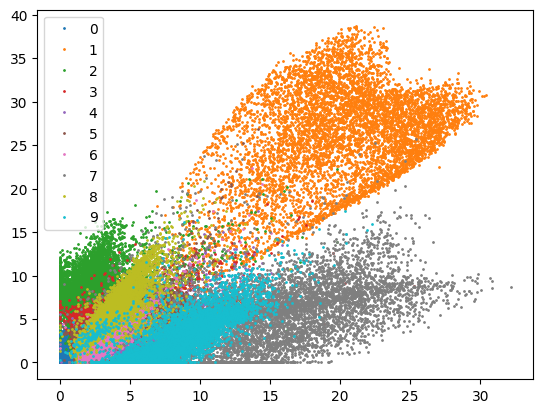

In [42]:
dec = uto_enc.encode(X).get()
for i in range(10):
    plt.plot(dec[train_label==i,0],dec[train_label==i, 1], ".", label=i, markersize=2)
plt.legend(loc='best')


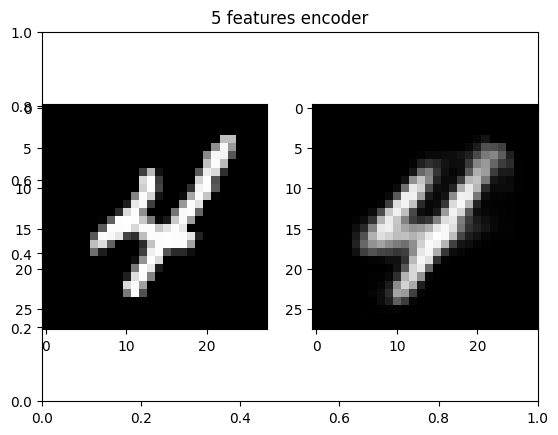

In [14]:
def show_img(img):
  if isinstance(img, cp.ndarray):
    img = img.get()
  img = img.reshape(28,-1)
  plt.imshow(img, cmap='gray')
i=9
plt.title("5 features encoder")
plt.subplot(1, 2, 1)
show_img(X[i])
plt.subplot(1, 2, 2)
show_img(uto_enc_5.mlp.forward(X[i])[0])
plt.show()

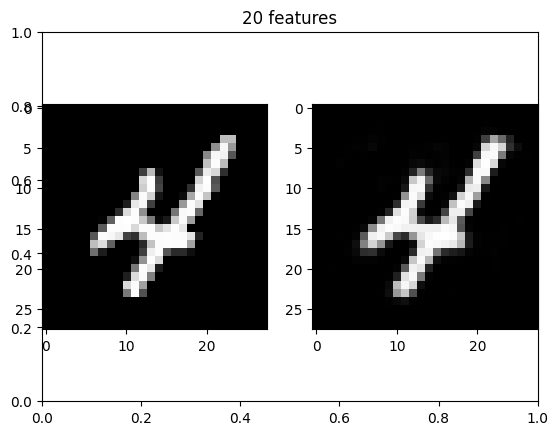

In [ ]:
def show_img(img):
  if isinstance(img, cp.ndarray):
    img = img.get()
  img = img.reshape(28,-1)
  plt.imshow(img, cmap='gray')
i=9
plt.title("20 features")
plt.subplot(1, 2, 1)
show_img(X[i])
plt.subplot(1, 2, 2)
show_img(uto_enc_20.mlp.forward(X[i])[0])
plt.show()

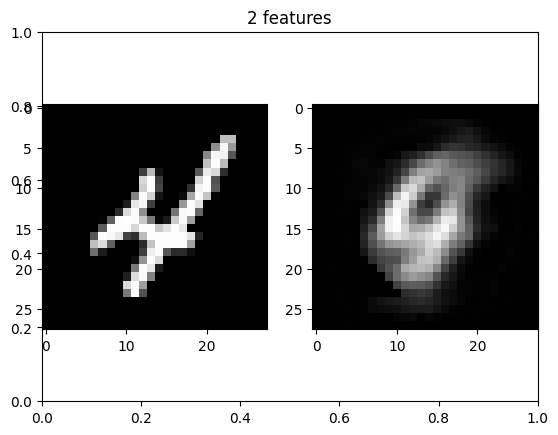

In [57]:
def show_img(img):
  if isinstance(img, cp.ndarray):
    img = img.get()
  img = img.reshape(28,-1)
  plt.imshow(img, cmap='gray')
i=9
plt.title("2 features")
plt.subplot(1, 2, 1)
show_img(X[i])
plt.subplot(1, 2, 2)
show_img(uto_enc.mlp.forward(X[i])[0])
plt.show()

In [ ]:
# fit svm
def fit_svm(auto_enc, C, gamma,i=7,j=9, max_epochs=30_000,debug=2):
    train_idxs = np.logical_or(train_label==i, train_label==j)
    X_svm_79 = auto_enc.encode(X[train_idxs]).T

    y_svm_79 = cp.array(train_label[train_idxs])
    y_svm_79 = cp.where(y_svm_79==i, 1,-1).astype(cp.int8)
    svm = mySVM(kernel='rbf',max_epochs=max_epochs,debug=debug, C=C, gamma=gamma, recal_bads=800)
    svm.fit(X_svm_79,y_svm_79)

    test_idxs = np.logical_or(test_label==i, test_label==j)
    X_test_svm_79 = auto_enc.encode(X_test[test_idxs]).T

    y_test_svm_79 = cp.array(test_label[test_idxs])
    y_test_svm_79 = cp.where(y_test_svm_79==i, 1,-1).astype(cp.int8)

    print(f"gamma: {gamma} C: {C} train acc: {100*(svm.predict(X_svm_79)==y_svm_79).sum()/len(y_svm_79):.2f}% test acc: {100*(svm.predict(X_test_svm_79)==y_test_svm_79).sum()/len(y_test_svm_79):.2f}%")
    return svm

fit svm and find the test accuracy for 7 and 9

In [21]:
svm = fit_svm(uto_enc,10,0.1,max_epochs=50_000) 

[SMO optimizer] epoch = 300: L = 84.55265  (# of support vectors = 185)
                alpha: max=2.655340424664546 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 120.6606 num of tights:288
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 152.97115  (# of support vectors = 321)
                alpha: max=2.655340424664546 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 88.3470 num of tights:303
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 317.73627  (# of support vectors = 452)
                alpha: max=4.083048564997299 min=0.0 orthogonal constraint=0.00
                bads: not bounded=410 bounded=2851
                sum moves: 191.5762 num of tights:199
                 train acc: 85.12
[SMO optimizer] epoch = 1200: L = 559.18606  (# of support vectors = 594)
                alpha: max=4.815916191924702 min=0.0 ort

In [ ]:
svm = fit_svm(uto_enc_5,10,0.01,max_epochs=50_000) 

[SMO optimizer] epoch = 300: L = 95.41680  (# of support vectors = 224)
                bads: not bounded=184 bounded=7012
                sum moves: 156.2596 num of tights:105
                 train acc: 86.52
[SMO optimizer] epoch = 600: L = 188.02834  (# of support vectors = 366)
                bads: not bounded=322 bounded=6428
                sum moves: 155.2488 num of tights:28
                 train acc: 88.44
[SMO optimizer] epoch = 900: L = 325.27053  (# of support vectors = 533)
                bads: not bounded=482 bounded=5417
                sum moves: 197.1406 num of tights:9
                 train acc: 91.40
[SMO optimizer] epoch = 1200: L = 446.57827  (# of support vectors = 674)
                bads: not bounded=624 bounded=3274
                sum moves: 194.7200 num of tights:15
                 train acc: 91.46
[SMO optimizer] epoch = 1500: L = 552.59694  (# of support vectors = 793)
                bads: not bounded=754 bounded=4466
                sum moves: 173.

In [134]:
svm = fit_svm(uto_enc_10,10,0.01,max_epochs=50_000) 

[SMO optimizer] epoch = 300: L = 50.80001  (# of support vectors = 213)
                bads: not bounded=158 bounded=4095
                sum moves: 136.6031 num of tights:104
                 train acc: 95.45
[SMO optimizer] epoch = 600: L = 102.33221  (# of support vectors = 370)
                bads: not bounded=316 bounded=2406
                sum moves: 139.1533 num of tights:21
                 train acc: 97.27
[SMO optimizer] epoch = 900: L = 148.87878  (# of support vectors = 472)
                bads: not bounded=452 bounded=2119
                sum moves: 118.8940 num of tights:22
                 train acc: 97.63
[SMO optimizer] epoch = 1200: L = 194.76124  (# of support vectors = 569)
                bads: not bounded=536 bounded=1755
                sum moves: 126.7916 num of tights:11
                 train acc: 97.86
[SMO optimizer] epoch = 1500: L = 244.62761  (# of support vectors = 649)
                bads: not bounded=622 bounded=1703
                sum moves: 136

In [135]:
svm = fit_svm(uto_enc_20,10,0.01,max_epochs=50_000) 

[SMO optimizer] epoch = 300: L = 52.39459  (# of support vectors = 254)
                bads: not bounded=194 bounded=4527
                sum moves: 157.3923 num of tights:138
                 train acc: 96.50
[SMO optimizer] epoch = 600: L = 82.06928  (# of support vectors = 417)
                bads: not bounded=364 bounded=3328
                sum moves: 113.4866 num of tights:18
                 train acc: 98.08
[SMO optimizer] epoch = 900: L = 108.58518  (# of support vectors = 554)
                bads: not bounded=498 bounded=2418
                sum moves: 103.9248 num of tights:15
                 train acc: 98.48
[SMO optimizer] epoch = 1200: L = 139.55297  (# of support vectors = 687)
                bads: not bounded=646 bounded=1713
                sum moves: 113.2228 num of tights:10
                 train acc: 98.84
[SMO optimizer] epoch = 1500: L = 167.41562  (# of support vectors = 791)
                bads: not bounded=754 bounded=1491
                sum moves: 105.

In [136]:
svm = fit_svm(uto_enc_40,10,0.01,max_epochs=50_000) 

[SMO optimizer] epoch = 300: L = 55.22663  (# of support vectors = 281)
                bads: not bounded=214 bounded=6483
                sum moves: 171.8720 num of tights:101
                 train acc: 96.35
[SMO optimizer] epoch = 600: L = 90.18096  (# of support vectors = 467)
                bads: not bounded=402 bounded=4852
                sum moves: 132.7656 num of tights:18
                 train acc: 97.20
[SMO optimizer] epoch = 900: L = 118.60862  (# of support vectors = 650)
                bads: not bounded=598 bounded=3418
                sum moves: 119.2673 num of tights:13
                 train acc: 98.20
[SMO optimizer] epoch = 1200: L = 140.01806  (# of support vectors = 776)
                bads: not bounded=738 bounded=2816
                sum moves: 104.4435 num of tights:9
                 train acc: 98.70
[SMO optimizer] epoch = 1500: L = 164.08161  (# of support vectors = 906)
                bads: not bounded=866 bounded=2684
                sum moves: 108.1

In [141]:
svm = fit_svm(uto_enc_80,10,0.01,max_epochs=50_000) 

[SMO optimizer] epoch = 300: L = 63.87761  (# of support vectors = 305)
                bads: not bounded=240 bounded=7138
                sum moves: 195.0479 num of tights:114
                 train acc: 95.05
[SMO optimizer] epoch = 600: L = 102.58847  (# of support vectors = 500)
                bads: not bounded=434 bounded=5212
                sum moves: 142.5856 num of tights:16
                 train acc: 96.96
[SMO optimizer] epoch = 900: L = 132.27776  (# of support vectors = 659)
                bads: not bounded=614 bounded=4166
                sum moves: 115.8504 num of tights:14
                 train acc: 98.01
[SMO optimizer] epoch = 1200: L = 159.26537  (# of support vectors = 824)
                bads: not bounded=776 bounded=3310
                sum moves: 111.6547 num of tights:18
                 train acc: 98.22
[SMO optimizer] epoch = 1500: L = 184.77262  (# of support vectors = 937)
                bads: not bounded=904 bounded=2797
                sum moves: 107

In [ ]:
# normalising before encoding
uto_enc_normed = auto_encoder([150,100,150], lr=0.01)
uto_enc_normed.fit(X,X_normer=X_normer)

(60000,)
first 81.88809284120497
epoch = 0 (lr=1.0): A = 87.6503220896941


KeyboardInterrupt: 

In [64]:
mlp = myMLP1(struct=[50,50,20], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)
A, C = mlp.fit(X, Y)

epoch = 0 (lr=0.1): C = 1.97967  A = 29.10%
epoch = 1 (lr=0.09): C = 1.31519  A = 48.40%
epoch = 2 (lr=0.081): C = 1.07119  A = 59.96%
epoch = 3 (lr=0.073): C = 0.90381  A = 66.78%
epoch = 4 (lr=0.066): C = 0.79269  A = 71.89%
epoch = 5 (lr=0.059): C = 0.57387  A = 80.94%
epoch = 6 (lr=0.053): C = 0.47857  A = 83.72%
epoch = 7 (lr=0.048): C = 0.42941  A = 86.31%
epoch = 8 (lr=0.043): C = 0.38018  A = 87.59%
epoch = 9 (lr=0.039): C = 0.39260  A = 87.19%
epoch = 10 (lr=0.035): C = 0.32959  A = 89.41%
epoch = 11 (lr=0.031): C = 0.32316  A = 90.09%


In [12]:
class bottleneck():
    def __init__(self, struct ,bn , lr=0.1, max_epochs=10, batch_size=10, annealing=0.9, debug=0):
        self.mlp = myMLP1(struct=struct,loss='ce', debug=debug, max_epochs=max_epochs, annealing=annealing, batch_size=batch_size,lr=lr, final_activation='softmax', random_state=1)
        self.bn = bn

    def fit(self,X,Y,X_normer=None):
        return self.mlp.fit(X,Y,X_normer=X_normer)

    def extract(self,X):
        Z = X
        # forward pass from all hidden layers
        for l in range(self.bn): 
            Z = relu(Z @ self.mlp.W[l] + self.mlp.b[l])
        return Z
    encode = extract


trying out different structures for extracting 20 features.

In [13]:
bn = bottleneck([100,20],2,lr=0.1,debug=2)
bn.fit(X,Y)
print(f"test acc: {(bn.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.6f}")

first C = 2.33313  A = 9.32%
epoch = 0 (lr=0.1): C = 0.11959  A = 96.34%
epoch = 1 (lr=0.09): C = 0.07074  A = 97.80%
epoch = 2 (lr=0.081): C = 0.05676  A = 98.22%
epoch = 3 (lr=0.073): C = 0.05410  A = 98.27%
epoch = 4 (lr=0.066): C = 0.04258  A = 98.58%
epoch = 5 (lr=0.059): C = 0.02931  A = 99.12%
epoch = 6 (lr=0.053): C = 0.03805  A = 98.75%
epoch = 7 (lr=0.048): C = 0.01440  A = 99.61%
epoch = 8 (lr=0.043): C = 0.01080  A = 99.72%
epoch = 9 (lr=0.039): C = 0.00663  A = 99.87%
test acc: 0.978400


In [101]:
bn = bottleneck([100,100,20],3,lr=0.1,debug=2)
bn.fit(X,Y)
print(f"test acc: {(bn.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.6f}")

epoch = 0 (lr=0.1): C = 0.14588  A = 95.53%
epoch = 1 (lr=0.09): C = 0.08487  A = 97.48%
epoch = 2 (lr=0.081): C = 0.05798  A = 98.24%
epoch = 3 (lr=0.073): C = 0.04617  A = 98.59%
epoch = 4 (lr=0.066): C = 0.03091  A = 98.99%
epoch = 5 (lr=0.059): C = 0.03058  A = 99.05%
epoch = 6 (lr=0.053): C = 0.02357  A = 99.21%
epoch = 7 (lr=0.048): C = 0.01044  A = 99.69%
epoch = 8 (lr=0.043): C = 0.00955  A = 99.73%
epoch = 9 (lr=0.039): C = 0.00621  A = 99.84%
epoch = 10 (lr=0.035): C = 0.00288  A = 99.94%
epoch = 11 (lr=0.031): C = 0.00151  A = 99.98%
test acc: 0.98140


In [14]:
bn_20 = bottleneck([500,20,50],2,lr=0.1,debug=2)
bn_20.fit(X,Y)
print(f"test acc: {(bn_20.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.6f}")

first C = 2.32290  A = 10.59%
epoch = 0 (lr=0.1): C = 0.11641  A = 96.44%
epoch = 1 (lr=0.09): C = 0.08038  A = 97.44%
epoch = 2 (lr=0.081): C = 0.03951  A = 98.82%
epoch = 3 (lr=0.073): C = 0.03537  A = 98.83%
epoch = 4 (lr=0.066): C = 0.02505  A = 99.23%
epoch = 5 (lr=0.059): C = 0.01364  A = 99.61%
epoch = 6 (lr=0.053): C = 0.01588  A = 99.50%
epoch = 7 (lr=0.048): C = 0.00585  A = 99.84%
epoch = 8 (lr=0.043): C = 0.00248  A = 99.95%
epoch = 9 (lr=0.039): C = 0.00143  A = 99.97%
test acc: 0.984700


In [ ]:
bn = bottleneck([1024,20,50],2,lr=0.1,debug=2)
bn.fit(X,Y)
(bn.mlp.predict(X_test).get()==test_label).sum()/len(test_label)

epoch = 0 (lr=0.1): C = 0.09741  A = 97.10%
epoch = 1 (lr=0.09): C = 0.11336  A = 96.18%
epoch = 2 (lr=0.081): C = 0.04190  A = 98.78%
epoch = 3 (lr=0.073): C = 0.03099  A = 99.01%
epoch = 4 (lr=0.066): C = 0.01911  A = 99.37%
epoch = 5 (lr=0.059): C = 0.01511  A = 99.50%
epoch = 6 (lr=0.053): C = 0.00618  A = 99.82%
epoch = 7 (lr=0.048): C = 0.00456  A = 99.88%
epoch = 8 (lr=0.043): C = 0.00834  A = 99.70%
epoch = 9 (lr=0.039): C = 0.00177  A = 99.96%
epoch = 10 (lr=0.035): C = 0.00059  A = 99.99%
epoch = 11 (lr=0.031): C = 0.00042  A = 100.00%


np.float64(0.9852)

In [ ]:
bn = bottleneck([500,20,100],2,lr=0.1,debug=2)
bn.fit(X,Y)
print(f"test acc: {(bn.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

epoch = 0 (lr=0.1): C = 0.09369  A = 97.22%
epoch = 1 (lr=0.09): C = 0.10153  A = 96.76%
epoch = 2 (lr=0.081): C = 0.06929  A = 97.85%
epoch = 3 (lr=0.073): C = 0.04575  A = 98.47%
epoch = 4 (lr=0.066): C = 0.02747  A = 99.15%
epoch = 5 (lr=0.059): C = 0.04653  A = 98.56%
epoch = 6 (lr=0.053): C = 0.01665  A = 99.48%
epoch = 7 (lr=0.048): C = 0.00550  A = 99.83%
epoch = 8 (lr=0.043): C = 0.00288  A = 99.93%
epoch = 9 (lr=0.039): C = 0.00231  A = 99.94%
epoch = 10 (lr=0.035): C = 0.00088  A = 99.99%
epoch = 11 (lr=0.031): C = 0.00067  A = 99.99%
test acc: 0.98310


In [31]:
bn = bottleneck([500,2,50],2,lr=0.1,debug=2)
bn.fit(X,Y)
print(f"test acc: {(bn.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.29715  A = 15.19%
epoch = 0 (lr=0.1): C = 0.32225  A = 92.23%
epoch = 1 (lr=0.09): C = 0.22817  A = 93.92%
epoch = 2 (lr=0.081): C = 0.17271  A = 95.47%
epoch = 3 (lr=0.073): C = 0.13599  A = 96.49%
epoch = 4 (lr=0.066): C = 0.12988  A = 96.62%
epoch = 5 (lr=0.059): C = 0.10870  A = 97.20%
epoch = 6 (lr=0.053): C = 0.09424  A = 97.57%
epoch = 7 (lr=0.048): C = 0.07370  A = 98.21%
epoch = 8 (lr=0.043): C = 0.07567  A = 98.12%
epoch = 9 (lr=0.039): C = 0.07095  A = 98.10%
test acc: 0.95510


finding best SVM for feature size of 20 in bottle neck

In [19]:
svm = fit_svm(bn_20, C=10, gamma=.1,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 8.19802  (# of support vectors = 108)
                alpha: max=0.9999340762616336 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 34.0547 num of tights:280
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 10.00974  (# of support vectors = 138)
                alpha: max=0.9999340762616336 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 8.2859 num of tights:276
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 16.41202  (# of support vectors = 196)
                alpha: max=1.0165621382163654 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=160 bounded=2102
                sum moves: 31.1780 num of tights:167
                 train acc: 99.83
[SMO optimizer] epoch = 1200: L = 28.37481  (# of support vectors = 295)
                alpha: max=1.1860882951444678 min=0.0 orth

In [20]:
svm = fit_svm(bn_20, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 4.45663  (# of support vectors = 69)
                alpha: max=0.7563433512499411 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 12.2583 num of tights:311
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 5.44614  (# of support vectors = 87)
                alpha: max=0.7563433512499411 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 2.9399 num of tights:290
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 10.94843  (# of support vectors = 115)
                alpha: max=0.8698941849398043 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=92 bounded=1009
                sum moves: 17.2234 num of tights:198
                 train acc: 99.93
[SMO optimizer] epoch = 1200: L = 20.37384  (# of support vectors = 189)
                alpha: max=1.4154683446780583 min=0.0 orthogon

BADS (not KKT equality)
a=0 and a=C 0
0<a<C 36


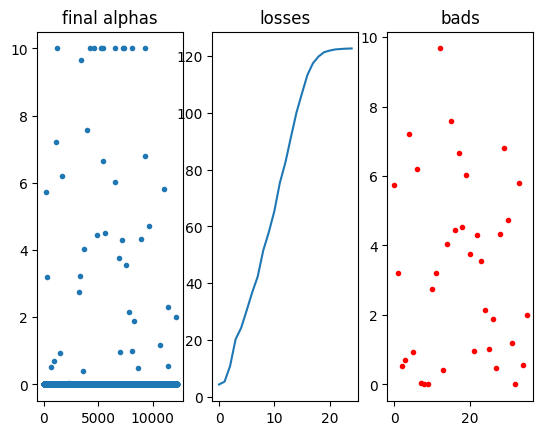

In [21]:
svm.plot()

fitting the bottle neck extractors

In [23]:
bn_2 = bottleneck([500,2,50],2,lr=0.1,debug=2)
bn_2.fit(X,Y)
print(f"test acc: {(bn_2.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.29715  A = 15.19%
epoch = 0 (lr=0.1): C = 0.32225  A = 92.23%
epoch = 1 (lr=0.09): C = 0.22817  A = 93.92%
epoch = 2 (lr=0.081): C = 0.17271  A = 95.47%
epoch = 3 (lr=0.073): C = 0.13599  A = 96.49%
epoch = 4 (lr=0.066): C = 0.12988  A = 96.62%
epoch = 5 (lr=0.059): C = 0.10870  A = 97.20%
epoch = 6 (lr=0.053): C = 0.09424  A = 97.57%
epoch = 7 (lr=0.048): C = 0.07370  A = 98.21%
epoch = 8 (lr=0.043): C = 0.07567  A = 98.12%
epoch = 9 (lr=0.039): C = 0.07095  A = 98.10%
test acc: 0.95510


In [25]:
bn_5 = bottleneck([500,5,50],2,lr=0.1,debug=2)
bn_5.fit(X,Y)
print(f"test acc: {(bn_5.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.31002  A = 9.80%
epoch = 0 (lr=0.1): C = 0.14992  A = 95.73%
epoch = 1 (lr=0.09): C = 0.13090  A = 95.83%
epoch = 2 (lr=0.081): C = 0.06142  A = 98.19%
epoch = 3 (lr=0.073): C = 0.04666  A = 98.68%
epoch = 4 (lr=0.066): C = 0.02950  A = 99.10%
epoch = 5 (lr=0.059): C = 0.01926  A = 99.46%
epoch = 6 (lr=0.053): C = 0.01596  A = 99.48%
epoch = 7 (lr=0.048): C = 0.01579  A = 99.51%
epoch = 8 (lr=0.043): C = 0.00633  A = 99.83%
epoch = 9 (lr=0.039): C = 0.00455  A = 99.87%
test acc: 0.98010


In [26]:
bn_10 = bottleneck([500,10,50],2,lr=0.1,debug=2)
bn_10.fit(X,Y)
print(f"test acc: {(bn_10.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.31005  A = 11.00%
epoch = 0 (lr=0.1): C = 0.10439  A = 96.82%
epoch = 1 (lr=0.09): C = 0.07117  A = 97.84%
epoch = 2 (lr=0.081): C = 0.06365  A = 98.04%
epoch = 3 (lr=0.073): C = 0.03492  A = 98.94%
epoch = 4 (lr=0.066): C = 0.02291  A = 99.27%
epoch = 5 (lr=0.059): C = 0.01583  A = 99.52%
epoch = 6 (lr=0.053): C = 0.01793  A = 99.45%
epoch = 7 (lr=0.048): C = 0.00884  A = 99.75%
epoch = 8 (lr=0.043): C = 0.00496  A = 99.84%
epoch = 9 (lr=0.039): C = 0.00198  A = 99.96%
test acc: 0.98330


In [27]:
bn_20 = bottleneck([500,20,50],2,lr=0.1,debug=2)
bn_20.fit(X,Y)
print(f"test acc: {(bn_20.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.32290  A = 10.59%
epoch = 0 (lr=0.1): C = 0.11641  A = 96.44%
epoch = 1 (lr=0.09): C = 0.08038  A = 97.44%
epoch = 2 (lr=0.081): C = 0.03951  A = 98.82%
epoch = 3 (lr=0.073): C = 0.03537  A = 98.83%
epoch = 4 (lr=0.066): C = 0.02505  A = 99.23%
epoch = 5 (lr=0.059): C = 0.01364  A = 99.61%
epoch = 6 (lr=0.053): C = 0.01588  A = 99.50%
epoch = 7 (lr=0.048): C = 0.00585  A = 99.84%
epoch = 8 (lr=0.043): C = 0.00248  A = 99.95%
epoch = 9 (lr=0.039): C = 0.00143  A = 99.97%
test acc: 0.98470


In [28]:
bn_40 = bottleneck([500,40,50],2,lr=0.1,debug=2)
bn_40.fit(X,Y)
print(f"test acc: {(bn_40.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.32728  A = 7.49%
epoch = 0 (lr=0.1): C = 0.16406  A = 94.52%
epoch = 1 (lr=0.09): C = 0.06122  A = 98.11%
epoch = 2 (lr=0.081): C = 0.05259  A = 98.28%
epoch = 3 (lr=0.073): C = 0.03447  A = 98.92%
epoch = 4 (lr=0.066): C = 0.02765  A = 99.15%
epoch = 5 (lr=0.059): C = 0.01798  A = 99.39%
epoch = 6 (lr=0.053): C = 0.01974  A = 99.44%
epoch = 7 (lr=0.048): C = 0.00521  A = 99.85%
epoch = 8 (lr=0.043): C = 0.00382  A = 99.90%
epoch = 9 (lr=0.039): C = 0.00115  A = 99.98%
test acc: 0.98480


In [29]:
bn_80 = bottleneck([500,80,50],2,lr=0.1,debug=2)
bn_80.fit(X,Y)
print(f"test acc: {(bn_80.mlp.predict(X_test).get()==test_label).sum()/len(test_label):.5f}")

first C = 2.31225  A = 10.21%
epoch = 0 (lr=0.1): C = 0.11289  A = 96.67%
epoch = 1 (lr=0.09): C = 0.08441  A = 97.39%
epoch = 2 (lr=0.081): C = 0.04661  A = 98.51%
epoch = 3 (lr=0.073): C = 0.02905  A = 99.09%
epoch = 4 (lr=0.066): C = 0.02597  A = 99.13%
epoch = 5 (lr=0.059): C = 0.01449  A = 99.55%
epoch = 6 (lr=0.053): C = 0.00935  A = 99.73%
epoch = 7 (lr=0.048): C = 0.00602  A = 99.81%
epoch = 8 (lr=0.043): C = 0.00164  A = 99.97%
epoch = 9 (lr=0.039): C = 0.00071  A = 99.99%
test acc: 0.98500


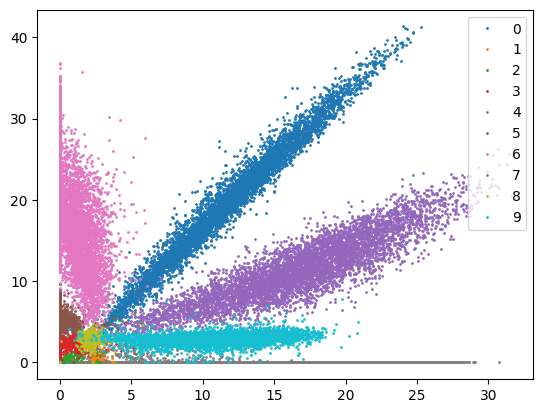

In [24]:
dec = bn_2.encode(X).get()
for i in range(10):
    plt.plot(dec[train_label==i,0],dec[train_label==i, 1], ".", label=i, markersize=2)
plt.legend(loc='best')


fitting the svms for 7 and 9

In [30]:
svm2 = fit_svm(bn_2, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 24.97706  (# of support vectors = 254)
                alpha: max=1.2507936023715978 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 48.2379 num of tights:291
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 29.85019  (# of support vectors = 325)
                alpha: max=1.2507936023715978 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 11.3364 num of tights:286
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 37.11992  (# of support vectors = 382)
                alpha: max=1.2507936023715978 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=368 bounded=1825
                sum moves: 22.1352 num of tights:179
                 train acc: 99.10
[SMO optimizer] epoch = 1200: L = 58.70186  (# of support vectors = 439)
                alpha: max=1.644705705886674 min=0.0 ort

In [31]:
svm5 = fit_svm(bn_5, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 4.75246  (# of support vectors = 101)
                alpha: max=0.6279204570287407 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 13.5760 num of tights:297
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 6.02420  (# of support vectors = 124)
                alpha: max=0.6279204570287407 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 4.0817 num of tights:308
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 10.68502  (# of support vectors = 161)
                alpha: max=0.9373130880535132 min=0.0 orthogonal constraint=0.00
                bads: not bounded=136 bounded=1477
                sum moves: 16.8887 num of tights:211
                 train acc: 99.96
[SMO optimizer] epoch = 1200: L = 19.34430  (# of support vectors = 213)
                alpha: max=1.3055103669100476 min=0.0 orthogo

In [32]:
svm10 = fit_svm(bn_10, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 3.42781  (# of support vectors = 78)
                alpha: max=0.7596629576460302 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 10.1109 num of tights:252
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 5.03126  (# of support vectors = 98)
                alpha: max=0.7596629576460302 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 4.2625 num of tights:267
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 10.40193  (# of support vectors = 120)
                alpha: max=0.7596629576460302 min=0.0 orthogonal constraint=0.00
                bads: not bounded=104 bounded=937
                sum moves: 19.9238 num of tights:211
                 train acc: 99.89
[SMO optimizer] epoch = 1200: L = 18.72835  (# of support vectors = 171)
                alpha: max=1.6392046177087618 min=0.0 orthogona

In [33]:
svm20 = fit_svm(bn_20, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 5.11135  (# of support vectors = 69)
                alpha: max=0.6711060652078752 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 13.4564 num of tights:326
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 6.45469  (# of support vectors = 93)
                alpha: max=0.6711060652078752 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 4.0405 num of tights:273
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 12.25262  (# of support vectors = 131)
                alpha: max=0.7874511409527858 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=98 bounded=888
                sum moves: 19.8024 num of tights:227
                 train acc: 99.93
[SMO optimizer] epoch = 1200: L = 20.61763  (# of support vectors = 193)
                alpha: max=1.4062226343216107 min=0.0 orthogon

In [34]:
svm40 = fit_svm(bn_40, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 5.80252  (# of support vectors = 92)
                alpha: max=0.8021497037622825 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 15.4558 num of tights:273
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 6.42988  (# of support vectors = 110)
                alpha: max=0.8021497037622825 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 2.1757 num of tights:302
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 10.39193  (# of support vectors = 151)
                alpha: max=0.8021497037622825 min=0.0 orthogonal constraint=0.00
                bads: not bounded=118 bounded=1011
                sum moves: 16.5981 num of tights:239
                 train acc: 99.97
[SMO optimizer] epoch = 1200: L = 20.30595  (# of support vectors = 200)
                alpha: max=1.1329218216699024 min=0.0 orthogo

In [35]:
svm80 = fit_svm(bn_80, C=10, gamma=.01,max_epochs=50_000)

[SMO optimizer] epoch = 300: L = 6.94981  (# of support vectors = 94)
                alpha: max=0.8533921955822213 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=0 bounded=12214
                sum moves: 18.3188 num of tights:280
                 train acc: 0.00
[SMO optimizer] epoch = 600: L = 8.55337  (# of support vectors = 122)
                alpha: max=0.8533921955822213 min=0.0 orthogonal constraint=0.00
                bads: not bounded=0 bounded=12214
                sum moves: 4.8824 num of tights:292
                 train acc: 0.00
[SMO optimizer] epoch = 900: L = 16.15956  (# of support vectors = 158)
                alpha: max=0.9023638735476887 min=0.0 orthogonal constraint=-0.00
                bads: not bounded=132 bounded=817
                sum moves: 24.3032 num of tights:213
                 train acc: 99.90
[SMO optimizer] epoch = 1200: L = 28.28606  (# of support vectors = 217)
                alpha: max=1.5087220540850286 min=0.0 orthogo

fitting the SVMs for 0 and 8 bottle neck

In [60]:
svm5 = fit_svm(bn_2, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)

epochs 13501 final obj: 702.45 sum all: 3213.48, #SVs: 93
gamma: 0.01 C: 10 train acc: 99.78% test acc: 99.03%


In [47]:
svm5 = fit_svm(bn_5, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm10 = fit_svm(bn_10, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm20 = fit_svm(bn_20, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm40 = fit_svm(bn_40, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm80 = fit_svm(bn_80, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)

epochs 7201 final obj: 67.78 sum all: 578.02, #SVs: 25
gamma: 0.01 C: 10 train acc: 99.99% test acc: 99.54%

epochs 5401 final obj: 58.84 sum all: 426.02, #SVs: 23
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.85%

epochs 5401 final obj: 56.45 sum all: 484.55, #SVs: 21
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.90%

epochs 5401 final obj: 58.24 sum all: 465.83, #SVs: 37
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.74%

epochs 5401 final obj: 55.63 sum all: 446.48, #SVs: 50
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.74%


In [61]:
svm5 = fit_svm(uto_enc, C=10, gamma=.1,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm5 = fit_svm(uto_enc_5, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm10 = fit_svm(uto_enc_10, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm20 = fit_svm(uto_enc_20, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm40 = fit_svm(uto_enc_40, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)
print()
svm80 = fit_svm(uto_enc_80, C=10, gamma=.01,max_epochs=50_000, i=0, j=8, debug=1)

epochs 50000 final obj: 10178.21 sum all: 30060.40, #SVs: 1994
gamma: 0.1 C: 10 train acc: 96.24% test acc: 96.01%

epochs 35701 final obj: 3244.18 sum all: 11063.20, #SVs: 421
gamma: 0.01 C: 10 train acc: 99.06% test acc: 98.98%

epochs 16201 final obj: 450.00 sum all: 2634.92, #SVs: 282
gamma: 0.01 C: 10 train acc: 99.96% test acc: 99.64%

epochs 12901 final obj: 170.24 sum all: 1411.12, #SVs: 825
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.59%

epochs 15001 final obj: 226.18 sum all: 1803.73, #SVs: 1525
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.74%

epochs 15901 final obj: 244.48 sum all: 1942.05, #SVs: 1648
gamma: 0.01 C: 10 train acc: 100.00% test acc: 99.64%
